# Broadcasting

Like _NumPy_ for Python, **Julia** supports "broadcasting" over array types - that is, performing an operation on the *elements* of an array, rather than on the array itself as a whole object.

Almost all Julia operations support being used in "broadcasting" mode - including function calls! In all cases, you just need to prepend the operation with a ".\" (a period / full stop) to use this functionality.

For example, given a simple array:

In [2]:
myarray = [1,2,3,4,5]

5-element Vector{Int64}:
 1
 2
 3
 4
 5

We can distribute the "add 2" operation over all its elements by simply typing (note `.+` not `+`):

In [2]:
2 .+ myarray

5-element Vector{Int64}:
 3
 4
 5
 6
 7

We can also distribute on the left and the right, where we get "element-wise" addition when arrays are both the same geometry:

In [3]:
myarray .+ myarray

5-element Vector{Int64}:
  2
  4
  6
  8
 10

And the outer product when they are a row and a column (here using `'` to form the transpose):

In [3]:
myarray' .+ myarray #the ' operator forms the transpose of the array

5×5 Matrix{Int64}:
 2  3  4  5   6
 3  4  5  6   7
 4  5  6  7   8
 5  6  7  8   9
 6  7  8  9  10

As mentioned above, we can even distribute function calls - the `()` operator - over our list!

In [4]:
?iseven  #demonstrate how the online docs work

search: iseven isinteractive



```
iseven(x::Number) -> Bool
```

Return `true` if `x` is an even integer (that is, an integer divisible by 2), and `false` otherwise.

!!! compat "Julia 1.7"
    Non-`Integer` arguments require Julia 1.7 or later.


# Examples

```jldoctest
julia> iseven(9)
false

julia> iseven(10)
true
```


In [5]:
iseven.(myarray)

5-element BitVector:
 0
 1
 0
 1
 0

This kind of "implicit iteration" is very powerful, and can be used to very consisely represent a number of transformations.
For example, making use of the Julia "ImageShow" package family to naturally display a 2d matrix as an image...

In [6]:
using ImageCore, ImageInTerminal, ImageShow

We can define a simple function - the Mandelbrot set membership function:

In [7]:
function mk(c)
  i = 0; z = 0
  while i < 255 && abs(z) < 2.0
    z = z^2 + c
    i += 1
  end
  i
end

mk (generic function with 1 method)

And a matrix representing a subset of the complex plane:

In [8]:
argand = [ (i+j*1im) / 100 for i in -200:200, j in -200:200 ] ;


And then simply apply a composed function - using `@.` to denote every operation should be broadcasted - to calculate the Mandelbrot set for all points, map them to a value from 0 to 1 and then represent them all as Grayscale pixels:

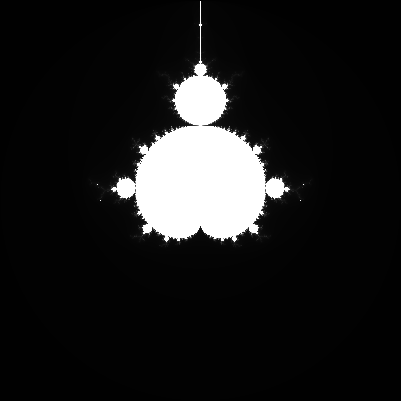

In [9]:
@. Gray(mk(argand) / 255)

One interesting performance characteristics to know about broadcasting in Julia is that sometimes it would "[fuse](https://julialang.org/blog/2018/05/extensible-broadcast-fusion/)" the functions together, thus avoid allocating intermediate arrays.

In other words: `@. f(g(h(xs)))` is not going to allocate `hs = h.(xs)` then `gs = g.(hs)` and so on, instead it only allocate once for the final product.

This is possible because broadcast operation (`.`) is part of the Julia syntax and handled differently, user can also customize broadcasting behavior of their own data types.

Julia's code introspection tools - which we're just demonstrating here so you know they exist - also demonstrate this. Here, we're using the `@code_lowered` macro to show what Julia's interpretation of a chain of broadcasted operations is:

In [10]:
arr = [0,1,2,3,4]

@code_lowered( mk.(2 .* arr) .+ 5 )

CodeInfo(
1 ─ %1 = Main.:+
│   %2 = Main.mk
│   %3 = Base.broadcasted(Main.:*, x1, x2)
│   %4 = Base.broadcasted(%2, %3)
│   %5 = Base.broadcasted(%1, %4, x3)
│   %6 = Base.materialize(%5)
└──      return %6
)

You can see that the special `Base.broadcasted` representation here wraps the relevant operations, allowing them to be optimised using a single pre-allocated temporary object, before being `materialize`d into the final output.